In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import PyTorchClassifier
from art.utils import load_mnist

%matplotlib inline

In [2]:
# Step 0: Define the neural network model, return logits instead of activation in forward method

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, stride=1)
        self.conv_2 = nn.Conv2d(in_channels=4, out_channels=10, kernel_size=5, stride=1)
        self.fc_1 = nn.Linear(in_features=4 * 4 * 10, out_features=100)
        self.fc_2 = nn.Linear(in_features=100, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 10)
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x


# Step 1: Load the MNIST dataset

(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

# Step 1a: Swap axes to PyTorch's NCHW format

x_train = np.swapaxes(x_train, 1, 3).astype(np.float32)
x_test = np.swapaxes(x_test, 1, 3).astype(np.float32)

# Step 2: Create the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)

# Step 2a: Define the loss function and the optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Step 3: Create the ART classifier

classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)

# Step 4: Train the ART classifier

classifier.fit(x_train, y_train, batch_size=64, nb_epochs=3)

# Step 5: Evaluate the ART classifier on benign test examples

predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 98.14%


In [5]:
# Generate (untargeted) adversarial test examples
np.random.seed(0)

eps_bounds = np.linspace(0, 0.9, 10) # [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
sample_images = np.zeros((10, 10, 1, 28, 28), dtype=np.float32)
acc = [0.9803]

shuffler = np.random.permutation(len(x_test))
x_test_shuffled = x_test[shuffler]
y_test_shuffled = y_test[shuffler]

visited = []

for j in range(x_test_shuffled.shape[0]):
    if len(visited) == 10:
        break

    y = np.argmax(y_test_shuffled[j])
    if y in visited:
        continue

    visited.append(y)
    sample_images[0][y] = x_test_shuffled[j]

for i, eps in enumerate(eps_bounds[1:]):
    attack = FastGradientMethod(estimator=classifier, eps=eps)
    x_test_adv = attack.generate(x=x_test_shuffled)
    
    # Evaluate the ART classifier on adversarial test examples
    predictions = classifier.predict(x_test_adv)
    accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test_shuffled, axis=1)) / len(y_test_shuffled)
    acc.append(accuracy)
    print(f'epsilon: {eps}')
    print(f'Accuracy on adversarial test examples: {accuracy * 100:.2f}%')
    print('=' * 50)
    
    visited = []

    for j in range(x_test_adv.shape[0]):
        if len(visited) == 10:
            break

        y = np.argmax(y_test_shuffled[j])
        if y in visited:
            continue

        pred = np.argmax(predictions[j])
        if y == pred:
            continue

        visited.append(y)
        sample_images[i+1][y] = x_test_adv[j]

epsilon: 0.1
Accuracy on adversarial test examples: 73.54%
epsilon: 0.2
Accuracy on adversarial test examples: 40.77%
epsilon: 0.30000000000000004
Accuracy on adversarial test examples: 24.76%
epsilon: 0.4
Accuracy on adversarial test examples: 18.41%
epsilon: 0.5
Accuracy on adversarial test examples: 15.51%
epsilon: 0.6000000000000001
Accuracy on adversarial test examples: 14.63%
epsilon: 0.7000000000000001
Accuracy on adversarial test examples: 14.43%
epsilon: 0.8
Accuracy on adversarial test examples: 15.09%
epsilon: 0.9
Accuracy on adversarial test examples: 16.10%


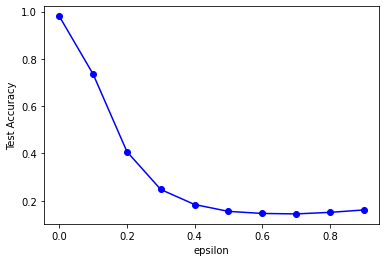

In [6]:
plt.plot(eps_bounds, acc, marker='o', color='b')
plt.xlabel("epsilon")
plt.ylabel("Test Accuracy");

(-0.5, 297.5, 297.5, -0.5)

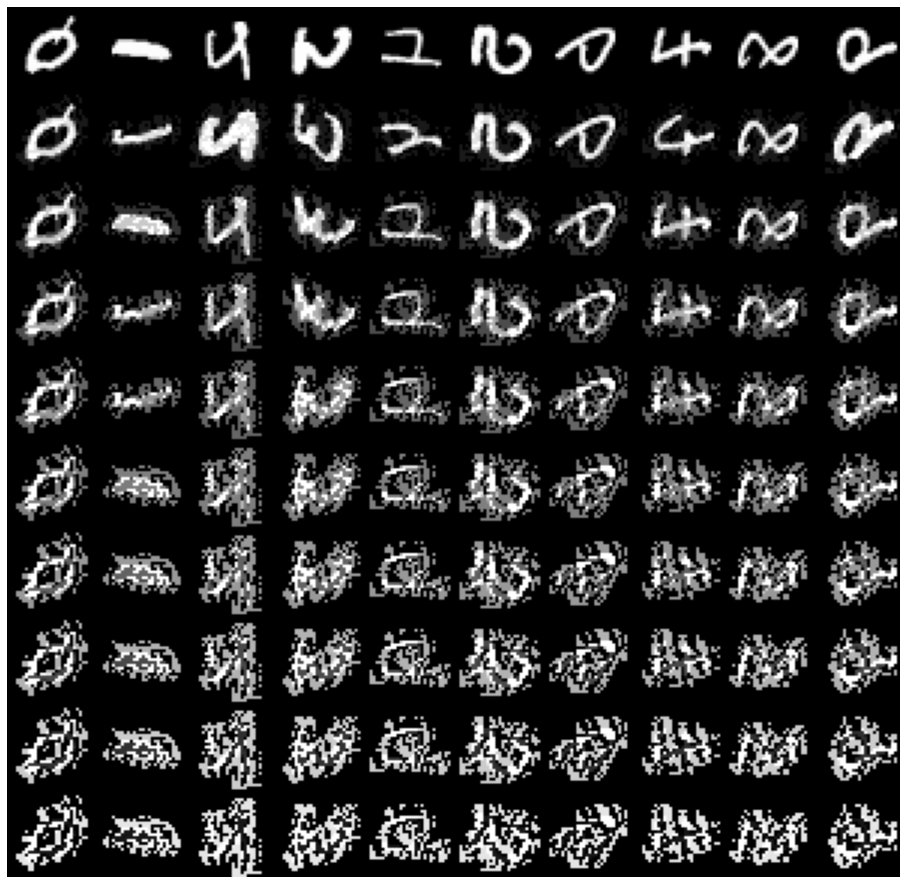

In [26]:
# Define a function that stitches the 28 * 28 numpy arrays
# together into a collage.
def stitch_images(images, y_img_count, x_img_count, margin = 2):
    
    # Dimensions of the images
    img_width = images[0][0].shape[1]
    img_height = images[0][0].shape[2]
    
    width = y_img_count * img_width + (y_img_count - 1) * margin
    height = x_img_count * img_height + (x_img_count - 1) * margin
    stitched_images = np.zeros((width, height, 3))

    # Fill the picture with our saved filters
    for i in range(y_img_count):
        for j in range(x_img_count):
            img = images[i][j][0]

            if len(img.shape) == 2:
                img = np.dstack([img] * 3)

            stitched_images[(img_width + margin) * i: (img_width + margin) * i + img_width,
                            (img_height + margin) * j: (img_height + margin) * j + img_height, :] = img

    return stitched_images


adv_comparison = stitch_images(sample_images, 10, 10)

plt.figure(figsize = (16, 16))
plt.imshow(adv_comparison, aspect='auto')
plt.xlabel("Digits")
plt.ylabel('Epsilon')
plt.axis('off')